# **From Stone to State: Nation-building with Cultural Infrastructure via Resource Mobilization in the Ancient Mediterranian region**

# Project on law and economics course (New Economic School)

# *Author: Aleksandra Vasileva*



Importing libararies

In [92]:
pip install contextily >> None

In [93]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, shape
import ast
import contextily as ctx
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import box
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import re
import matplotlib.colors as mcolors

Downloading the data

In [94]:
stones = pd.read_excel('stones.xlsx')
stones.rename(columns = {'Latitude':"Lat", 'Longitude': 'Long'}, inplace = True)
stones['geometry'] = stones.apply(lambda row: Point(row['Long'], row['Lat']), axis=1)

In [95]:
stones.columns

Index(['Site', 'Lat', 'Long', 'Location', 'Country', 'Province', 'Material',
       'Bibliography', 'geometry'],
      dtype='object')

In [96]:
stones.head(2)

Site        Lat       Long              Location  Country   Province  \
0  Aba Vela  43.938661  15.164293  In the Zadar islands  Croatia   Dalmatia   
1    Abdera  40.949722  24.983056  Just north of Abdera   Greece  Macedonia   

                     Material          Bibliography  \
0     Limestone, used locally  Škegro 2006: 161-162   
1  White marble, used locally       TIR Philippi 35   

                      geometry  
0  POINT (15.164293 43.938661)  
1  POINT (24.983056 40.949722)

In [97]:
stones.Material.unique()

array(['Limestone, used locally', 'White marble, used locally',
       'Red-pink and white marble (cipollino rosso), used locally and exported regionally and inter-regionally',
       'Travertine, used locally',
       'Gypsum, limestone and sandstone, used locally in the Roman period',
       'Green-grey and white streaked marble (cipollino); used locally from the Classical period but only exported widely in the Roman Imperial',
       'White marble (Paros-3), used locally and exported regionally and inter- regionally',
       'White-grey marble, used locally', 'Marble, used locally',
       'White marble, used locally, perhaps regionally',
       'Sandstone, used locally',
       'Black marble (nero antico), used locally, perhaps regionally',
       'Several varieties of alabaster (alabastri di Constantina), used locally and exported regionally',
       'A variety of banded alabaster similar to Egyptian onyx, used in Archaic period and later, and exported in Roman period; and a fine-

In [98]:
# List of known material types (simplified example - expand with your full list)
KNOWN_MATERIALS = [
    'marble', 'limestone', 'granite', 'sandstone', 'alabaster', 'travertine', 'sandstone',
    'porphyry', 'basalt', 'breccia', 'schist', 'serpentine', 'tuff', 'gypsum', 'andesite', 'porphyry'

]

def extract_specific_material(text):
    """
    Extracts the specific material from a description string.
    """
    if not isinstance(text, str):
        return None

    # Clean the text (lowercase, remove punctuation)
    clean_text = re.sub(r'[^\w\s-]', ' ', text.lower())

    # Find all matching materials (longest first for specificity)
    matches = []
    for material in sorted(KNOWN_MATERIALS, key=len, reverse=True):
        if re.search(r'\b' + re.escape(material) + r'\b', clean_text):
            matches.append(material)

    # Return the most specific match (longest) if found
    if matches:
        return max(matches, key=len).title()  # Return with capitalization
    return None  # Or return 'Unknown' if preferred

# Example usage:
stones['Specific_material'] = stones['Material'].apply(extract_specific_material)

In [99]:
stones.head()

Site        Lat       Long  \
0      Aba Vela  43.938661  15.164293   
1        Abdera  40.949722  24.983056   
2         Abkuk  37.279444  27.582500   
3       Abu Ras  30.968888  29.651111   
4  Acque Albule  41.954722  12.745833   

                                            Location  Country   Province  \
0                               In the Zadar islands  Croatia   Dalmatia   
1                               Just north of Abdera   Greece  Macedonia   
2  Between villages of Abkuk (ancient Basilicus) ...   Turkey       Asia   
3  On the coast just north of the western end of ...    Egypt   Aegyptus   
4                                 Near ancient Tibur    Italy   Italia I   

                                            Material  \
0                            Limestone, used locally   
1                         White marble, used locally   
2  Red-pink and white marble (cipollino rosso), u...   
3                            Limestone, used locally   
4                           Travertine, used locally   

                                        Bibliography  \
0                               Škegro 2006: 161-162   
1                                    TIR Philippi 35   
2  Mielsch 1985: 46; Gnoli 1988: 243-\n245; Monna...   
3         J. Röder 1967; Klemm and Klemm 2008: 36-39   
4                   Mari 1991; Veloccia Rinaldi 1991   

                      geometry Specific_material  
0  POINT (15.164293 43.938661)         Limestone  
1  POINT (24.983056 40.949722)            Marble  
2    POINT (27.5825 37.279444)            Marble  
3  POINT (29.651111 30.968888)         Limestone  
4  POINT (12.745833 41.954722)        Travertine

In [100]:
stones.columns

Index(['Site', 'Lat', 'Long', 'Location', 'Country', 'Province', 'Material',
       'Bibliography', 'geometry', 'Specific_material'],
      dtype='object')

In [101]:
gdf_stones = gpd.GeoDataFrame(stones, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3857)

In [102]:
df = pd.read_csv('pleiades-locations-20250422.csv.gz')

def parse_geojson(g):
    try:
        return shape(ast.literal_eval(g))
    except:
        return None

df['geometry'] = df['geometry'].apply(parse_geojson)
df = df.dropna(subset=['geometry'])

df['featureType'] = df['featureType'].replace('settlement,', 'settlement')
df['featureType'] = df['featureType'].replace('mountain,', 'mountain')
df['featureType'] = df['featureType'].replace('river,', 'river')
df['featureType'] = df['featureType'].replace('villa,', 'villa')
df['featureType'] = df['featureType'].replace('theatre,', 'theatre')
df['featureType'] = df['featureType'].replace('temple_2,', 'temple_2')

df = df[~df['geometry'].apply(lambda g: isinstance(g, (Polygon, MultiPolygon)))]

gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
gdf = gdf.to_crs(epsg=3857)

<ipython-input-102-b16dc4e30fa6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['featureType'] = df['featureType'].replace('settlement,', 'settlement')
<ipython-input-102-b16dc4e30fa6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['featureType'] = df['featureType'].replace('mountain,', 'mountain')
<ipython-input-102-b16dc4e30fa6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [103]:
df.head(5)

authors  \
0                                         Becker, J.   
1                                         Becker, J.   
2   Spann, P., D. R. Talbert, T. Elliott, S. Gillies   
3  Spann, P., R. Horne, R. Talbert, T. Elliott, R...   
4   Spann, P., D. R. Talbert, T. Elliott, S. Gillies   

                                                bbox               created  \
0       13.4119837, 42.082885, 13.4119837, 42.082885  2013-07-15T17:16:48Z   
1       11.62797, 42.4193742, 11.6288024, 42.4200183  2013-07-11T15:48:53Z   
2         -3.606772, 39.460299, -3.606772, 39.460299  2011-03-10T00:05:52Z   
3  -1.10341660496, 38.0622869617, -0.621575751277...  2022-08-30T11:18:41Z   
4         -2.403309, 37.241792, -2.403309, 37.241792  2011-03-09T23:39:28Z   

     creators  currentVersion  \
0     jbecker             7.0   
1     jbecker             4.0   
2  P.O. Spann             1.0   
3  P.O. Spann             NaN   
4  P.O. Spann             1.0   

                                         description featureType  \
0  The post-Roman settlement at Alba Fucens. Loca...  settlement   
1  A major urban sanctuary at Vulci with a long p...   temple-2,   
2                            1M scale point location     unknown   
3  Centerline/arc of label location used on the B...       label   
4                            1M scale point location     unknown   

                                            geometry  \
0                       POINT (13.4119837 42.082885)   
1  LINESTRING (11.6285463 42.4193742, 11.62797 42...   
2                        POINT (-3.606772 39.460299)   
3  MULTILINESTRING ((-1.103416604957735 38.062286...   
4                        POINT (-2.403309 37.241792)   

                             id locationPrecision  ...               pid  \
0  location-of-borgo-medioevale           precise  ...  /places/48210385   
1     location-of-tempio-grande           precise  ...  /places/48210386   
2          darmc-location-20192           precise  ...    /places/265876   
3     batlas-map-label-location           precise  ...    /places/265877   
4          darmc-location-19495           precise  ...    /places/265878   

     reprLat                    reprLatLong   reprLong            tags  \
0  42.082885           42.082885,13.4119837  13.411984  extant remains   
1  42.419709    42.4197091413,11.6283843149  11.628384             NaN   
2  39.460299            39.460299,-3.606772  -3.606772             NaN   
3  38.428230  38.4282302524,-0.879814039831  -0.879814             NaN   
4  37.241792            37.241792,-2.403309  -2.403309             NaN   

  timePeriods                                 timePeriodsKeys  \
0           M                             mediaeval-byzantine   
1        ACHR  archaic,classical,hellenistic-republican,roman   
2         HRL       hellenistic-republican,roman,late-antique   
3          HR                    hellenistic-republican,roman   
4          HR                    hellenistic-republican,roman   

  timePeriodsRange                            title  \
0     640.0,1453.0  OSM location of Borgo Medievale   
1     -750.0,300.0    OSM location of Tempio Grande   
2     -330.0,640.0             DARMC location 20192   
3     -330.0,300.0        BAtlas Map Label Location   
4     -330.0,300.0             DARMC location 19495   

                                uid  
0  3e81cf966a1407978021141372c3f921  
1  b2d62017b95615f275a79666f79a6631  
2  62e35ae520c733fd1b3d538cfc93024d  
3  b0c1ed9539164dd680086922ef4c77a5  
4  802d8a7041359a15a43fb861d201d5ce  

[5 rows x 25 columns]

In [104]:
df.featureType.unique()

array(['settlement', 'temple-2,', 'unknown', 'label', 'island', 'villa',
       'cape', 'settlement-modern', 'water-open', 'archaeological-site',
       'river', 'canal,river', 'mountain', 'archaeological-site,hill',
       'station,', 'aqueduct,', 'aqueduct', 'bridge', 'bridge,', 'dam',
       'lighthouse', 'lake', 'fort-2', nan, 'tumulus', 'tumulus,',
       'island,', 'mouth', 'fort', 'archaeological-site,settlement',
       'archaeological-site,villa', 'archipelago', 'reservoir', 'tomb',
       'fortified-settlement', 'archipelago,', 'ruin', 'water-open,',
       'fort,', 'archaeological-site,settlement,tell', 'bath', 'church,',
       'temple-2', 'monument', 'quarry', 'amphitheatre', 'monument,',
       'tomb,', 'architecturalcomplex', 'cemetery', 'bath,', 'mine-2',
       'fountain', 'arch', 'sanctuary,', 'theatre', 'region',
       'province-2', 'fort-2,archaeological-site', 'settlement-modern,',
       'spring', 'garden-hortus', 'city-wall', 'cave', 'basilica',
       'defensiv

In [105]:
category_map = {
    # Christian-related
    'church': 'church',
    'church-2': 'church',
    'chapel': 'church',
    'cathedral': 'church',
    'abbey': 'church',
    'abbey-church': 'church',
    'basilica': 'church',
    'monastery': 'church',

    # Islamic
    'mosque': 'mosque',

    # Jewish
    'synagogue': 'synagogue',

    # Hindu/Buddhist/Other Temples
    'temple': 'temple',
    'temple-2': 'temple',
    'shrine': 'temple',
    'stupa': 'temple',
    'sanctuary': 'temple',

    # Ceremonial/Spiritual sites
    'tomb': 'tomb',
    'pyramid': 'tomb',
    'tumulus': 'tomb',
    'mausoleum': 'tomb',

    # Entertainment
    'theatre': 'theatre',
    'cinema': 'theatre',
    'opera': 'theatre',
    'amphitheatre': 'theatre',

    # Defensive/Residential
    'castle': 'castle',
    'palace': 'castle',
    'fort': 'castle',
    'citadel': 'castle',

    # Other architectural
    'architecturalcomplex': 'complex',
    'monument': 'monument',
    'plaza': 'monument',
    'cemetery': 'cemetery',
    'findspot': 'other',
    'settlement': 'settlement',
    'cave': 'cave',
    'ruin': 'ruin',

    # Default
    'archaeological-site': 'archaeological',
}

def extract_main_feature(ftype):
    if not isinstance(ftype, str):
        return 'other'
    tokens = [t.strip().lower() for t in re.split('[-,]', ftype)]
    for token in tokens:
        if token in category_map:
            return category_map[token]
    return 'other'



df['main_feature'] = df['featureType'].apply(extract_main_feature)

<ipython-input-106-1987599d68b1>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_counts.values, y=feature_counts.index, palette="magma_r")


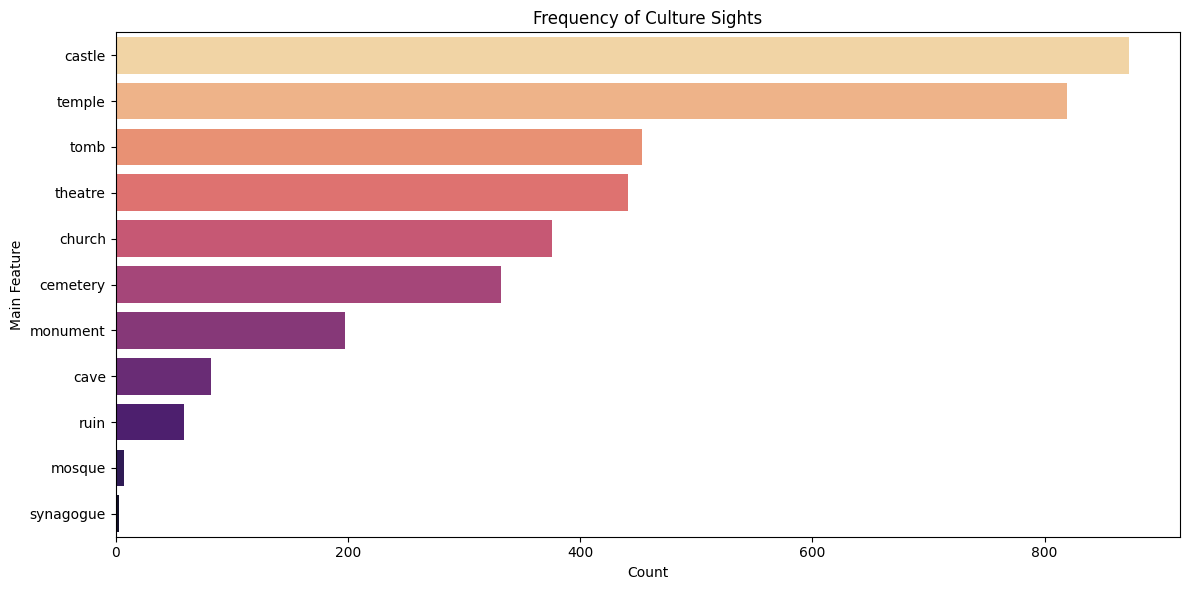

In [106]:
# Count unique main features

# Filter out rows where main_feature is 'other'
df_culture = df[~df['main_feature'].isin(['other', 'settlement', 'complex'])].copy()

feature_counts = df_culture['main_feature'].value_counts().sort_values(ascending=False)

# Plot feature counts
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_counts.values, y=feature_counts.index, palette="magma_r")
plt.title('Frequency of Culture Sights')
plt.xlabel('Count')
plt.ylabel('Main Feature')
plt.tight_layout()
#plt.savefig("count_of_culture", dpi=300)
plt.show()


Plotting geographical locations from the data

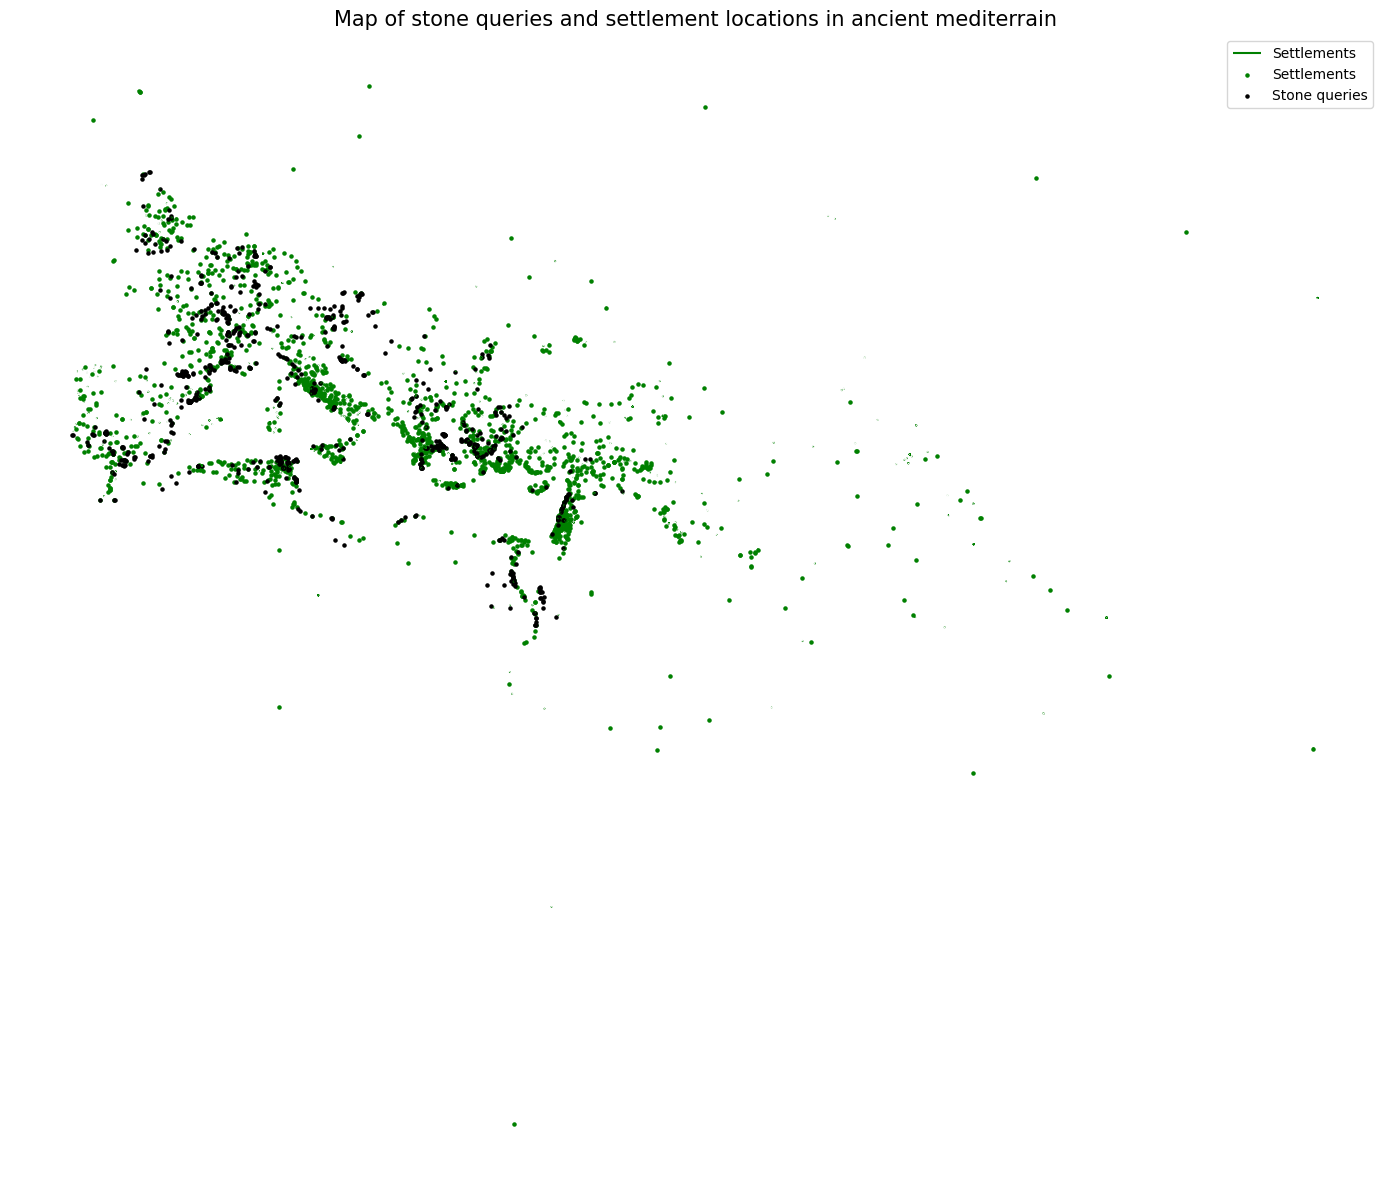

In [107]:
# --- Plot ---
fig, ax = plt.subplots(figsize=(14, 12))


gdf[gdf['featureType'] == 'settlement'].plot(ax=ax, color='green', markersize=5, label='Settlements')

gdf_stones.plot(ax=ax, color='black', markersize=5, label='Stone queries')

# Optional: Add basemap
# ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainBackground)

ax.set_title("Map of stone queries and settlement locations in ancient mediterrain", fontsize=15)
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [108]:
bbox = ( -2.5e6, 2.5e6, 4e6, 5.5e6 )  # (xmin, ymin, xmax, ymax)

# Filter gdf to within this bounding box
gdf_clipped = gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]

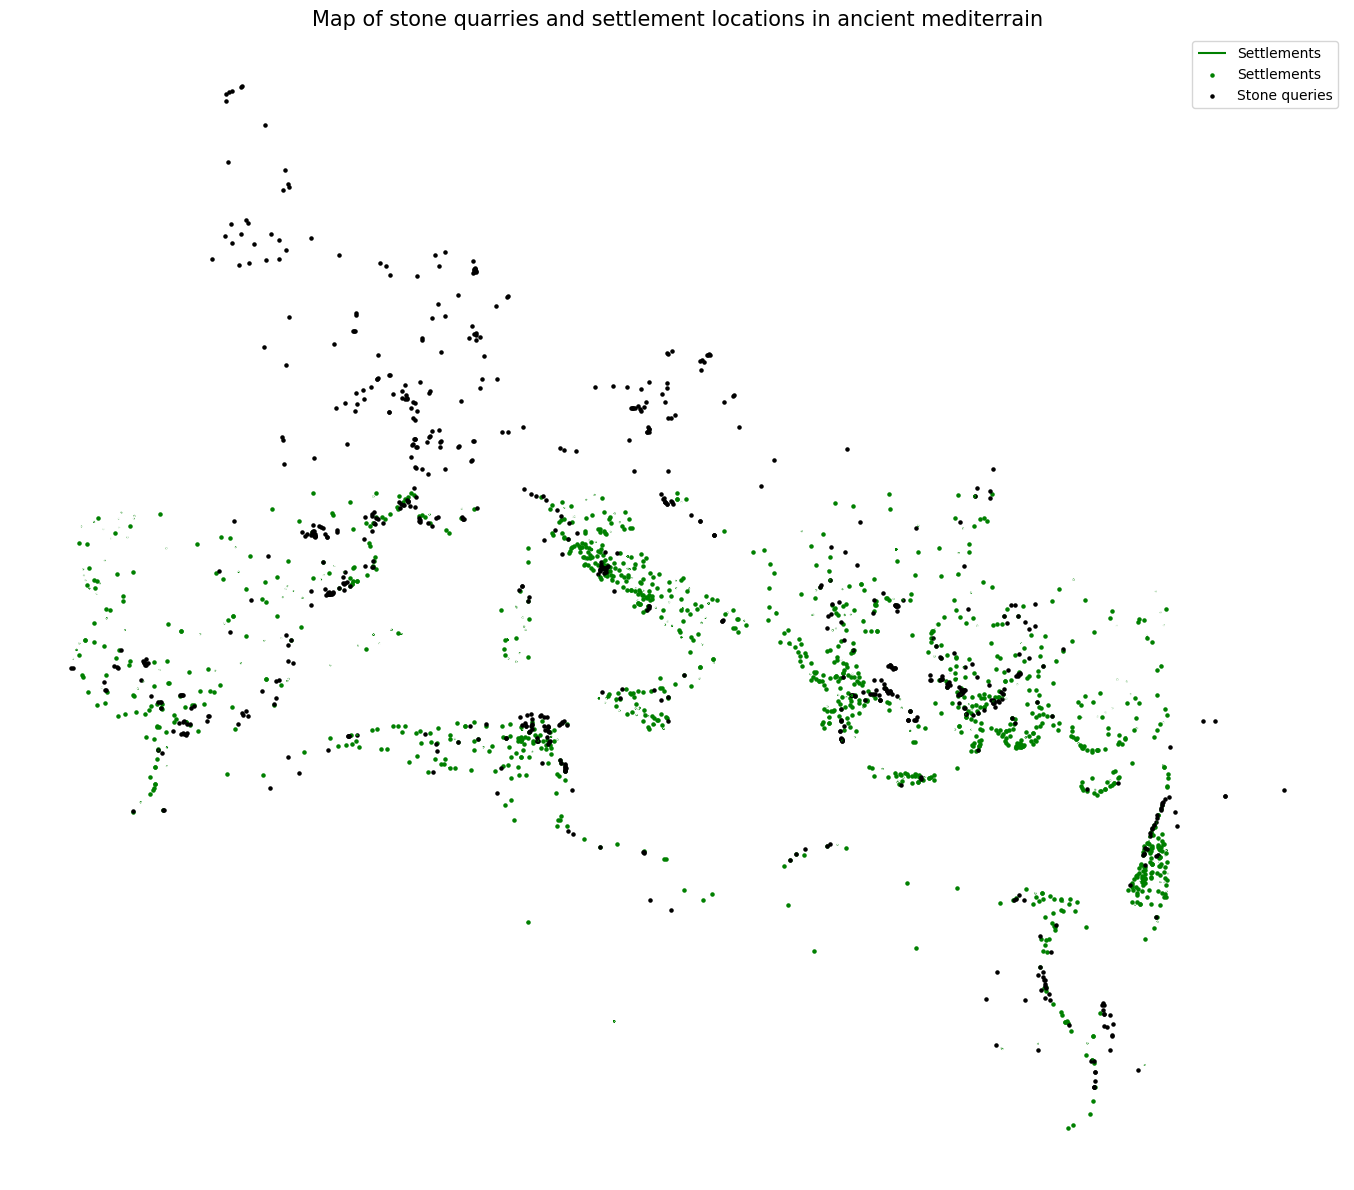

In [109]:
# --- Plot ---
fig, ax = plt.subplots(figsize=(14, 12))


gdf_clipped[gdf_clipped['featureType'] == 'settlement'].plot(ax=ax, color='green', markersize=5, label='Settlements')

gdf_stones.plot(ax=ax, color='black', markersize=5, label='Stone queries')

# Optional: Add basemap
# ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainBackground)

ax.set_title("Map of stone quarries and settlement locations in ancient mediterrain", fontsize=15)
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()
#

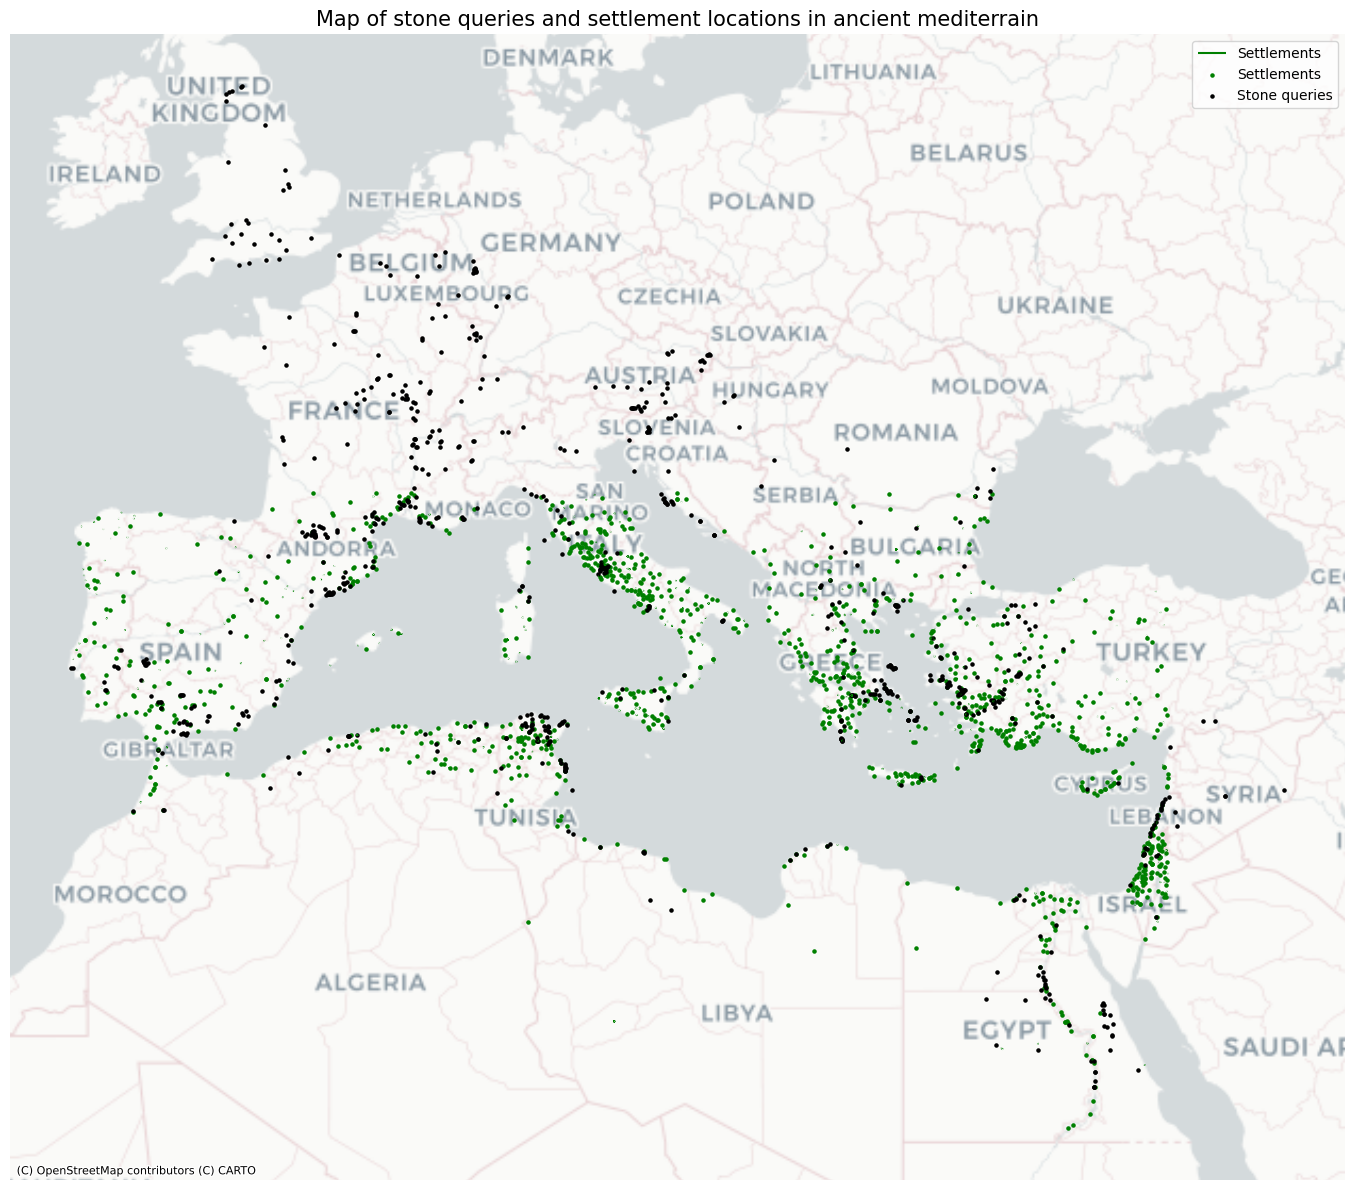

In [110]:
# --- Plot ---
fig, ax = plt.subplots(figsize=(14, 12))


gdf_clipped[gdf_clipped['featureType'] == 'settlement'].plot(ax=ax, color='green', markersize=5, label='Settlements')

gdf_stones.plot(ax=ax, color='black', markersize=5, label='Stone queries')

# add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron )

ax.set_title("Map of stone queries and settlement locations in ancient mediterrain", fontsize=15)
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()

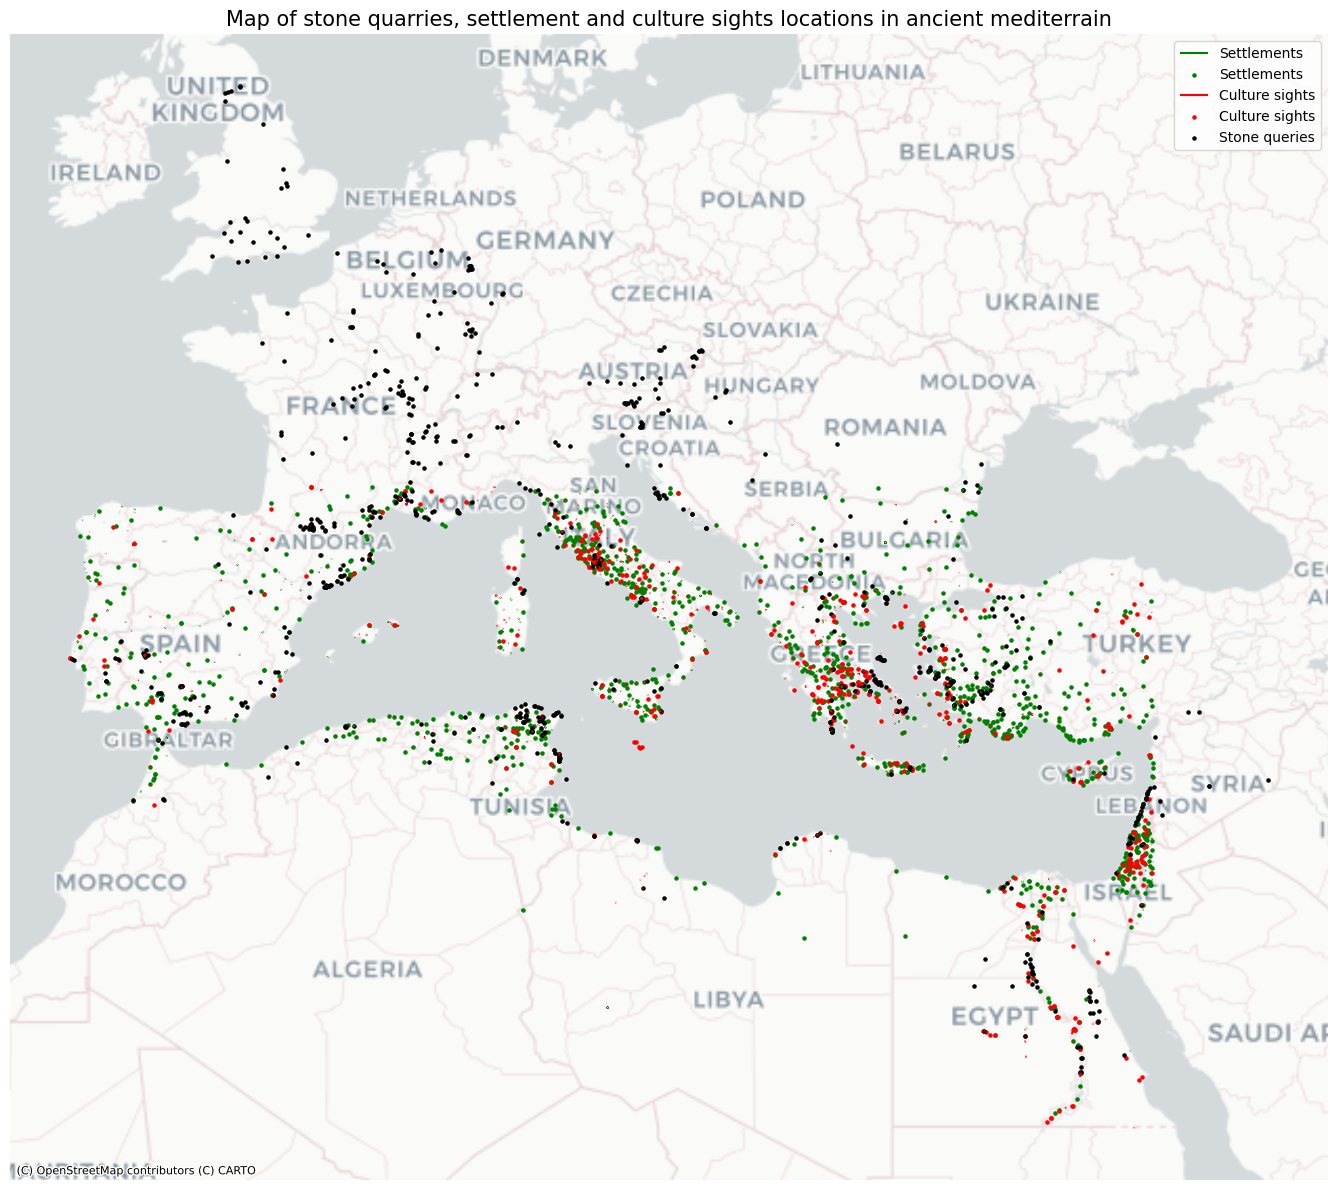

In [111]:
# --- Plot ---
fig, ax = plt.subplots(figsize=(14, 12))


gdf_clipped[gdf_clipped['featureType'] == 'settlement'].plot(ax=ax, color='green', markersize=5, label='Settlements')
culture_sights = ['church', 'church,', 'sanctuary', 'sanctuary,','amphitheatre', 'church-2', 'temple-2', 'temple-2,', 'archaeological-site']
gdf_clipped[gdf_clipped['featureType'].isin(culture_sights)].plot(ax=ax, color='red', markersize=5, label='Culture sights')

gdf_stones.plot(ax=ax, color='black', markersize=5, label='Stone queries')

# Optional: Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron )

ax.set_title("Map of stone quarries, settlement and culture sights locations in ancient mediterrain", fontsize=15)
ax.legend()
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Specific Stones

<ipython-input-112-bae07d3f464f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=material_counts.values, y=material_counts.index, palette="viridis_r")


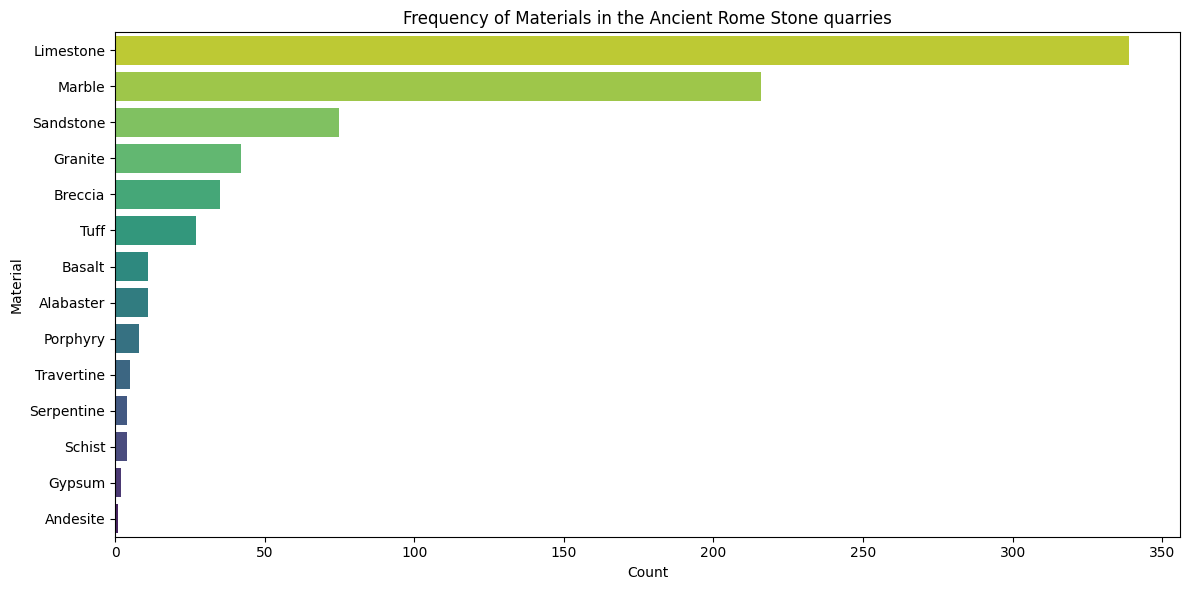

In [112]:
# Count unique materials
material_counts = stones['Specific_material'].value_counts().sort_values(ascending=False)

# Plot material counts
plt.figure(figsize=(12, 6))
sns.barplot(x=material_counts.values, y=material_counts.index, palette="viridis_r")
plt.title('Frequency of Materials in the Ancient Rome Stone quarries')
plt.xlabel('Count')
plt.ylabel('Material')
plt.tight_layout()
#plt.savefig("count_of_materials", dpi = 300)
plt.show()


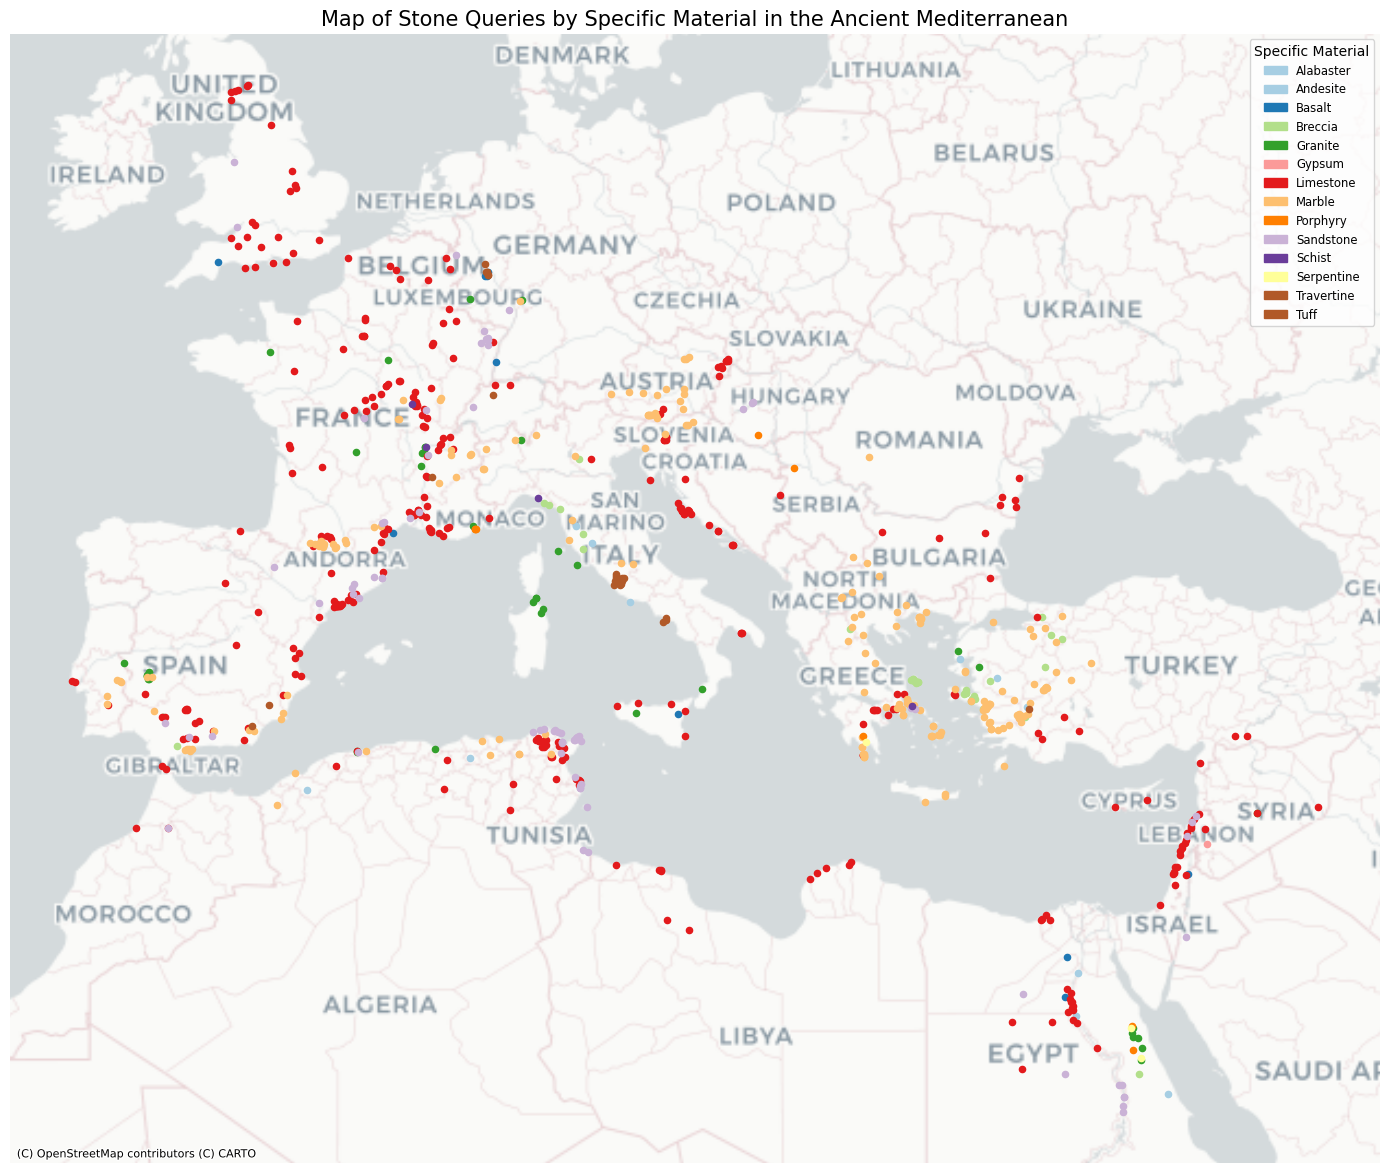

In [113]:
gdf_stones_web = gdf_stones.to_crs(epsg=3857)

# Get unique materials
materials = gdf_stones_web['Specific_material'].dropna().unique()
materials.sort()

# Assign a color to each material
cmap = plt.get_cmap('Paired', len(materials))
color_dict = {mat: cmap(i) for i, mat in enumerate(materials)}

# Plot base
fig, ax = plt.subplots(figsize=(14, 12))

# Plot each material with its assigned color
for mat in materials:
    subset = gdf_stones_web[gdf_stones_web['Specific_material'] == mat]
    subset.plot(ax=ax, color=color_dict[mat], markersize=20)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Title and legend
ax.set_title("Map of Stone Queries by Specific Material in the Ancient Mediterranean", fontsize=15)

# Custom legend
handles = [mpatches.Patch(color=color_dict[mat], label=mat) for mat in materials]
ax.legend(handles=handles, title="Specific Material", loc='upper right', fontsize='small', title_fontsize='medium', frameon=True)

# Clean up
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("map_types_of_stone", dpi = 300)
plt.show()

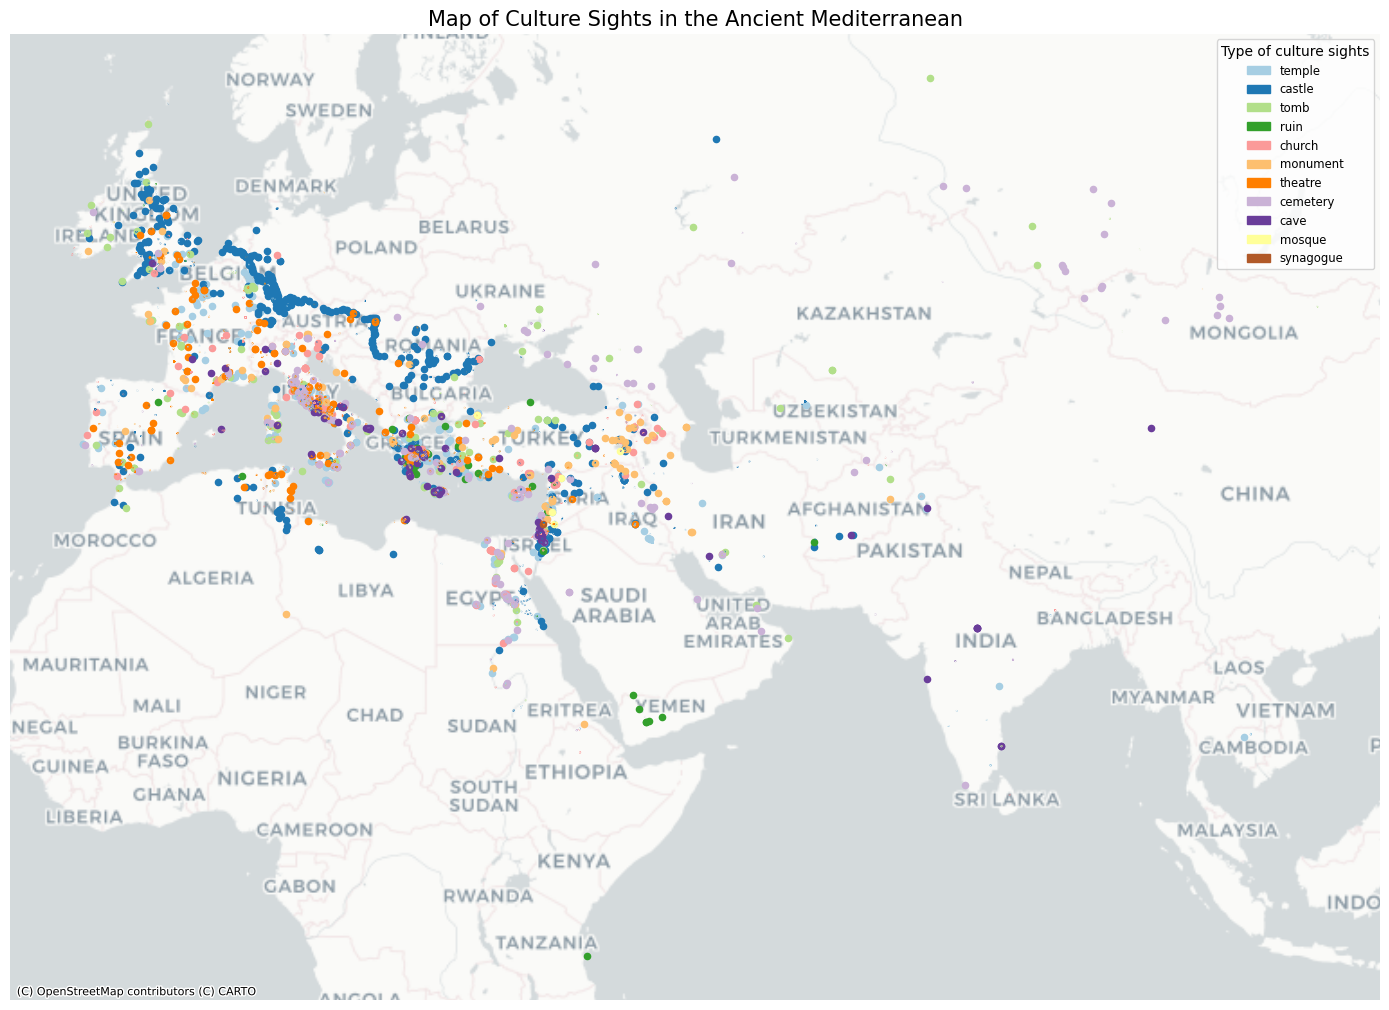

In [114]:
gdf_culture = gpd.GeoDataFrame(df_culture, geometry='geometry', crs='EPSG:4326')

bbox = (-2.5e6, 4e6, 2.5e6, 5.5e6)  # (xmin, ymin, xmax, ymax)

# Create a polygon from the bounding box
bbox_polygon = box(bbox[0], bbox[1], bbox[2], bbox[3])

# Create GeoDataFrame from the bounding box polygon
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs="EPSG:4326")

# Clip the original GeoDataFrame with the bounding box
gdf_culture_clipped = gpd.clip(gdf_culture, bbox_gdf)

gdf_culture_web = gdf_culture.to_crs(epsg=3857)

culture_types = gdf_culture_web['main_feature'].dropna().unique()


# Assign a color to each material
cmap = plt.get_cmap('Paired', len(culture_types))
color_dict = {mat: cmap(i) for i, mat in enumerate(culture_types)}

# Plot base
fig, ax = plt.subplots(figsize=(14, 12))

# Plot each material with its assigned color
for culture_type in culture_types:
    subset = gdf_culture_web[gdf_culture_web['main_feature'] == culture_type]
    subset.plot(ax=ax, color=color_dict[culture_type], markersize=20)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Title and legend
ax.set_title("Map of Culture Sights in the Ancient Mediterranean", fontsize=15)

# Custom legend
handles = [mpatches.Patch(color=color_dict[culture_type], label=culture_type) for culture_type in culture_types]
ax.legend(handles=handles, title="Type of culture sights", loc='upper right', fontsize='small', title_fontsize='medium', frameon=True)

# Clean up
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("map_types_of_culture", dpi = 300)
plt.show()

**Regression analysis**

In [115]:
# Define bounding box & grid
bounds = gdf_clipped.total_bounds
xmin, ymin, xmax, ymax = bounds
grid_size = 50000  # in meters

cols = np.arange(xmin, xmax, grid_size)
rows = np.arange(ymin, ymax, grid_size)
polygons = [box(x, y, x + grid_size, y + grid_size) for x in cols for y in rows]
grid = gpd.GeoDataFrame({'geometry': polygons}, crs='EPSG:3857')

#  Extract relevant features
culture_sights = [
    'church', 'church,', 'sanctuary', 'sanctuary,',
    'amphitheatre', 'church-2', 'temple-2', 'temple-2,',
    'archaeological-site'
]
cultural = gdf_clipped[gdf_clipped['featureType'].isin(culture_sights)]


# Spatial joins
# Count of cultural sights in each cell
join_cult = gpd.sjoin(grid, cultural, predicate='contains')
cult_counts = join_cult.groupby(join_cult.index).size()
grid['culture_count'] = grid.index.map(cult_counts).fillna(0).astype(int)

# Presence of stone quarries
join_stone = gpd.sjoin(grid, gdf_stones, how='left', predicate='contains')
stone_presence = join_stone.groupby(join_stone.index).size().gt(0)
grid['has_stone'] = stone_presence.reindex(grid.index, fill_value=False).astype(int)


#  Run regression
X = sm.add_constant(grid[['has_stone']])
y = grid['culture_count']
model = sm.OLS(y, X).fit()

# Summary with stars
def add_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

summary_df = pd.DataFrame({
    'coef': model.params,
    'pval': model.pvalues,
    'stars': model.pvalues.apply(add_stars)
})
summary_df['coef_with_stars'] = summary_df.apply(lambda row: f"{row['coef']:.4f}{row['stars']}", axis=1)

print("\n=== Coefficients with Significance Stars ===")
print(summary_df[['coef_with_stars']])
print(model.summary())


=== Coefficients with Significance Stars ===
          coef_with_stars
has_stone       0.1038***
                            OLS Regression Results                            
Dep. Variable:          culture_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 11 May 2025   Prob (F-statistic):                nan
Time:                        20:29:36   Log-Likelihood:                -19077.
No. Observations:               11830   AIC:                         3.816e+04
Df Residuals:                   11829   BIC:                         3.816e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [116]:
# Define bounding box & grid
bounds = gdf_clipped.total_bounds
xmin, ymin, xmax, ymax = bounds
grid_size = 50000  # in meters

cols = np.arange(xmin, xmax, grid_size)
rows = np.arange(ymin, ymax, grid_size)
polygons = [box(x, y, x + grid_size, y + grid_size) for x in cols for y in rows]
grid = gpd.GeoDataFrame({'geometry': polygons}, crs='EPSG:3857')

# Extract relevant features  , 'villa', 'villa,'
culture_sights = [
    'church', 'church,', 'sanctuary', 'sanctuary,',
    'amphitheatre', 'church-2', 'temple-2', 'temple-2,',
    'archaeological-site'
]
cultural = gdf_clipped[gdf_clipped['featureType'].isin(culture_sights)]


# Spatial joins
# Count of cultural sights in each cell
join_cult = gpd.sjoin(grid, cultural, predicate='contains')
cult_counts = join_cult.groupby(join_cult.index).size()
grid['culture_count'] = grid.index.map(cult_counts).fillna(0).astype(int)

# Count of stone quarries in each cell
join_stone = gpd.sjoin(grid, gdf_stones, predicate='contains')
stone_counts = join_stone.groupby(join_stone.index).size()
grid['stone_count'] = grid.index.map(stone_counts).fillna(0).astype(int)


# Run regression
X = sm.add_constant(grid[['stone_count']])
y = grid['culture_count']
model = sm.OLS(y, X).fit()

# Summary with stars
def add_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

summary_df = pd.DataFrame({
    'coef': model.params,
    'pval': model.pvalues,
    'stars': model.pvalues.apply(add_stars)
})
summary_df['coef_with_stars'] = summary_df.apply(lambda row: f"{row['coef']:.4f}{row['stars']}", axis=1)

print("\n=== Coefficients with Significance Stars ===")
print(summary_df[['coef_with_stars']])
print(model.summary())


=== Coefficients with Significance Stars ===
            coef_with_stars
const             0.0486***
stone_count       0.8958***
                            OLS Regression Results                            
Dep. Variable:          culture_count   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     1526.
Date:                Sun, 11 May 2025   Prob (F-statistic):          4.36e-314
Time:                        20:29:37   Log-Likelihood:                -18359.
No. Observations:               11830   AIC:                         3.672e+04
Df Residuals:                   11828   BIC:                         3.674e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]


In [117]:
grid['culture_count'].unique(), grid['stone_count'].unique()

(array([  0,   2,   1,   6,   4,   3,   7,  10, 105,  12,   8,  19,   5,
         11,  16,   9,  14,  15,  36]),
 array([ 0,  1,  2,  3,  4,  5,  8,  7, 15,  9, 12,  6, 13]))

Downloading data to further transfer to Stata for regression analysis

Uncomment to download the data

In [118]:
# # Define all grid sizes (in meters)
# grid_sizes = [5000, 10000, 15000, 20000, 25000, 30000, 40000, 50000]

# # Get bounds from clipped data
# bounds = gdf_clipped.total_bounds
# xmin, ymin, xmax, ymax = bounds

# for grid_size in grid_sizes:
#     # Create grid
#     cols = np.arange(xmin, xmax, grid_size)
#     rows = np.arange(ymin, ymax, grid_size)
#     polygons = [box(x, y, x + grid_size, y + grid_size) for x in cols for y in rows]
#     grid = gpd.GeoDataFrame({'geometry': polygons}, crs='EPSG:3857')

#     # Filter cultural sights
#     culture_sights = [
#         'church', 'church,', 'sanctuary', 'sanctuary,',
#         'amphitheatre', 'church-2', 'temple-2', 'temple-2,',
#         'archaeological-site'
#     ]
#     cultural = gdf_clipped[gdf_clipped['featureType'].isin(culture_sights)]

#     # Spatial joins
#     join_cult = gpd.sjoin(grid, cultural, predicate='contains')
#     cult_counts = join_cult.groupby(join_cult.index).size()
#     grid['culture_count'] = grid.index.map(cult_counts).fillna(0).astype(int)

#     # Count of stone quarries in each cell
#     join_stone = gpd.sjoin(grid, gdf_stones, predicate='contains')
#     stone_counts = join_stone.groupby(join_stone.index).size()
#     grid['stone_count'] = grid.index.map(stone_counts).fillna(0).astype(int)

#     # Prepare for Stata: drop geometry
#     grid_df = grid.drop(columns='geometry')

#     # Export to Stata file (named by grid size)
#     filename = f"grid_{grid_size//1000}km.dta"
#     grid_df.to_stata(filename, write_index=False)


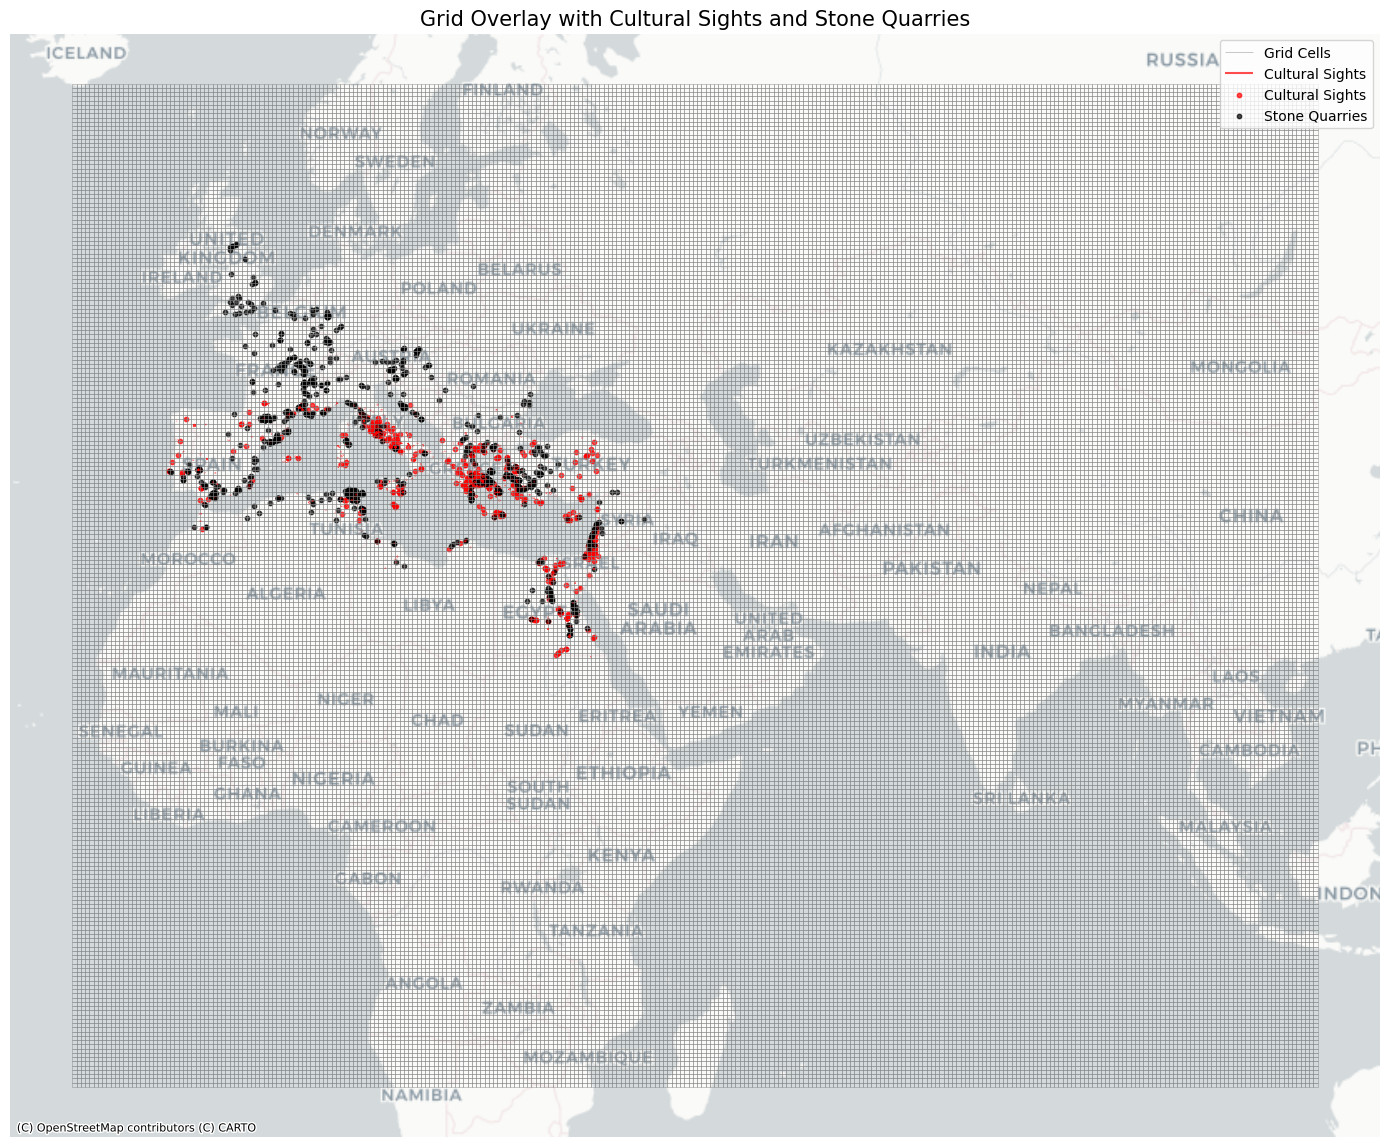

In [122]:
# Define grid over Web Mercator coordinates
bounds = gdf.total_bounds
xmin, ymin, xmax, ymax = bounds
grid_size = 50000  # 50km grid in meters

cols = np.arange(xmin, xmax + grid_size, grid_size)
rows = np.arange(ymin, ymax + grid_size, grid_size)
polygons = [box(x, y, x + grid_size, y + grid_size) for x in cols for y in rows]

grid_web = gpd.GeoDataFrame({'geometry': polygons}, crs='EPSG:3857')

# Reproject other datasets to match
cultural_web = cultural.to_crs(epsg=3857)
gdf_stones_web = gdf_stones.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(14, 12))

# Plot layers
grid_web.boundary.plot(ax=ax, linewidth=0.5, color='gray', alpha=0.6, label='Grid Cells')
cultural_web.plot(ax=ax, color='red', markersize=10, label='Cultural Sights', alpha=0.7)
gdf_stones_web.plot(ax=ax, color='black', markersize=10, label='Stone Quarries', alpha=0.7)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:3857')

# Style and cleanup
ax.set_title("Grid Overlay with Cultural Sights and Stone Quarries", fontsize=15)
ax.legend(loc='upper right', fontsize='medium')
ax.set_axis_off()
plt.tight_layout()
plt.show()
